In [73]:
from matplotlib.pyplot import imshow
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input, Dropout

# Definição do tamanho padrão para redimensionamento das imagens e batch size
img_size = (32, 32)
batch_size = 8
# Caminho onde estão as pastas com as classes de imagens
data_dir = "Data"

# Inicialização das listas que vão armazenar os caminhos das imagens e seus respectivos rótulos
image_paths = []
labels = []
# Leitura dos nomes das subpastas (cada uma representa uma classe)
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Percorre cada imagem dentro de cada pasta de classe, coletando os caminhos e os rótulos
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_idx[class_name])
            
# Conversão para arrays do NumPy
image_paths = np.array(image_paths)
labels = np.array(labels)

In [74]:
# Divisão inicial: 85% para treino + validação, 15% para teste
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)

# Nova divisão: 15% de X_temp para validação (equivale a 12.75% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15 / 0.85, stratify=y_temp, random_state=42
)


In [75]:
# Carrega a imagem do caminho (como escala de cinza), redimensiona e normaliza
def preprocess_image(path, label):
    img = load_img(path.numpy().decode(), color_mode='grayscale', target_size=img_size)
    img = img_to_array(img) / 255.0
    return img, label

# Adapta a função para ser compatível com tf.data (via py_function)
def tf_preprocess(path, label):
    img, label = tf.py_function(preprocess_image, [path, label], [tf.float32, tf.int64])
    img.set_shape((img_size[0], img_size[1], 1))
    label.set_shape(())
    return img, label

# Monta um dataset do TensorFlow com batching, mapeamento e pré-busca otimizados
def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=42)
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Criação dos datasets para treino, validação e teste
train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, y_test, shuffle=False)

print("Classes:", class_names)
print("Treino:", len(X_train), "Validação:", len(X_val), "Teste:", len(X_test))

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Treino: 19600 Validação: 4200 Teste: 4200


In [76]:
model = Sequential()

# Entrada: imagem 32x32 com 1 canal (grayscale)
model.add(Input(shape=(img_size[0], img_size[1], 1)))

# Primeira camada convolucional (32 filtros 3x3) com ReLU e padding
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduz a dimensão espacial pela metade
model.add(Dropout(0.25)) # Previne overfitting

# Segunda camada convolucional com mais filtros
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Achata os mapas de ativação para entrada na camada densa
model.add(Flatten())

# Camada totalmente conectada
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax')) # Saída para 4 classes com softmax

# Compilação do modelo com função de perda apropriada e otimizador Adamax
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,284 (1.07 MB)

 Trainable params: 281,284 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

None


In [77]:
# Interrompe o treinamento caso a validação pare de melhorar por 3 épocas seguidas
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Treinamento do modelo pelo número de épocas (ou menos, se early stopping for acionado)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.5159 - loss: 1.0367 - val_accuracy: 0.6612 - val_loss: 0.7810
Epoch 2/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6775 - loss: 0.7443 - val_accuracy: 0.7424 - val_loss: 0.6316
Epoch 3/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7481 - loss: 0.6172 - val_accuracy: 0.8019 - val_loss: 0.5225
Epoch 4/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7839 - loss: 0.5349 - val_accuracy: 0.7952 - val_loss: 0.5064
Epoch 5/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.8174 - loss: 0.4645 - val_accuracy: 0.8631 - val_loss: 0.3780
Epoch 6/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.8415 - loss: 0.4011 - val_accuracy: 0.8719 - val_loss: 0.3512
Epoch 7/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.8607 - loss: 0.3639 - val_accuracy: 0.8929 - val_loss: 0.3061
Epoch 8/20
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.8704 - loss: 

525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9507 - loss: 0.1474
Acurácia no teste: 0.9531
Perda no teste: 0.1406


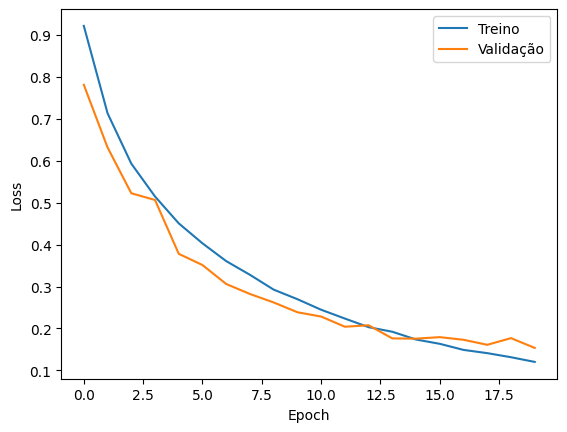

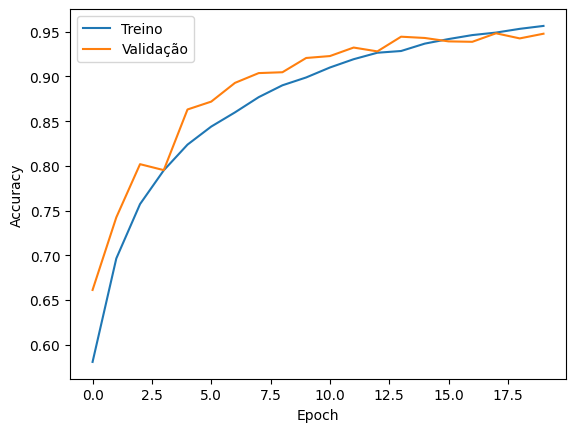

In [103]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test_ds)
print(f"Acurácia no teste: {test_acc:.4f}")
print(f"Perda no teste: {test_loss:.4f}")

# Visualização das curvas de perda (loss) durante o treinamento
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualização das curvas de acurácia (acuracy) durante o treinamento
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [79]:
# Função para carregar uma imagem e fazer a predição com o modelo treinado
def predict(path):
    print(f'Predicao de {path}')
    img = load_img(path, color_mode='grayscale', target_size=img_size) # Carrega e redimensiona
    img_array = img_to_array(img) / 255.0 # Normaliza os valores para [0,1]
    img_array = np.expand_dims(img_array, axis=0) # Adiciona dimensão do batch (1, H, W, C)

    res = model.predict_on_batch(img_array)

    # Retorna os índices das classes com maior probabilidade
    classification = np.where(res == np.amax(res))[1][0]
    imshow(img)
    print(str(res[0][classification] * 100) + '% Confidence This Is ' + class_names[classification])

    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.title(f"Classe prevista: {class_names[classification]}")
    plt.axis('off')
    plt.show()


Predizendo imagem aleatória de Very mild Dementia: OAS1_0161_MR1_mpr-4_126.jpg
Predicao de Data/Very mild Dementia/OAS1_0161_MR1_mpr-4_126.jpg
95.86109% Confidence This Is Very mild Dementia


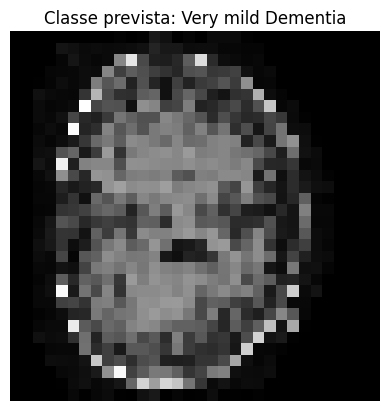

In [123]:
# Sorteia uma pasta de classe e uma imagem aleatória para testar a predição
import random

# Escolhe uma pasta (classe) aleatória
random_folder = random.choice([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])
folder_path = os.path.join(data_dir, random_folder)

# Escolhe um arquivo de imagem aleatório dessa pasta
file = random.choice([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Predizendo imagem aleatória de {random_folder}: {file}")
predict(os.path.join(folder_path, file))